## OverView
### overview
Successful models will incorporate some analysis of the impact of including different keywords or phrases, as well as making use of the structured data fields like location, hours or company.  Some of the structured data shown (such as category) is 'inferred' by Adzuna's own processes, based on where an ad came from or its contents, and may not be "correct" but is representative of the real data.

You will be provided with a training data set on which to build your model, which will include all variables including salary.  A second data set will be used to provide feedback on the public leaderboard.  After approximately 6 weeks, Kaggle will release a final data set that does not include the salary field to participants, who will then be required to submit their salary predictions against each job for evaluation.
### Job Data
The main dataset consists of a large number of rows representing individual job ads, and a series of fields about each job ad.  These fields are as follows:

Id - A unique identifier for each job ad

Title - A freetext field supplied to us by the job advertiser as the Title of the job ad.  Normally this is a summary of the job title or role.

FullDescription - The full text of the job ad as provided by the job advertiser.  Where you see ***s, we have stripped values from the description in order to ensure that no salary information appears within the descriptions.  There may be some collateral damage here where we have also removed other numerics.

LocationRaw - The freetext location as provided by the job advertiser.

LocationNormalized - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location.  Our normaliser is not perfect!

ContractType - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

ContractTime - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

Company - the name of the employer as supplied to us by the job advertiser.

Category - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.  We know there is a lot of noise and error in this field.

SalaryRaw - the freetext salary field we received in the job advert from the advertiser.

SalaryNormalised - the annualised salary interpreted by Adzuna from the raw salary.  Note that this is always a single value based on the midpoint of any range found in the raw salary.  This is the value we are trying to predict.

SourceName - the name of the website or advertiser from whom we received the job advert. 

All of the data is real, live data used in job ads so is clearly subject to lots of real world noise, including but not limited to: ads that are not UK based, salaries that are incorrectly stated, fields that are incorrectly normalised and duplicate adverts.

### Target And How To Do
The goal of this study is based on historical recruitment data and then predicting the salary for each row of data in each test set. The standard for measuring the quality of a model is MAE.   
FullDescription is a paragraph that describes the position. Subsequent use, n-gram, tfidf build features. For feature Title and FullDescription. You can divide the words first, then count the frequency of occurrence of each word (or phrase, n-gram, n take 2), remove the low-frequency words (groups), and then use the resulting vocabulary as a feature vector (or substitute tfidf) Add to each sample (feature dimensions are large, but sparse).   
After these features are established, modeling can begin. Our goal is to predict the salary provided by a job, and the salary forecast can be viewed as a regression problem, so it can be modeled using linear regression, ridge regression, and neural networks.

In [1]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.cross_validation import KFold # old version

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

cur_dir = os.getcwd()

## Data Cleaning and Data Preparation

### Cleaning NaN 

In [2]:
# Using a small subset of original data
# full data can be found on Kaggle : https://www.kaggle.com/c/job-salary-prediction
Salaries = pd.read_csv("Salary_Train_sample.csv", encoding = "ISO-8859-1")
# See how many null values are in each column
Salaries.isnull().sum(axis=0)

Id                        0
Title                     1
FullDescription           0
LocationRaw               0
LocationNormalized        0
ContractType          10780
ContractTime           8893
Company                6111
Category                  0
SalaryRaw                 0
SalaryNormalized          0
SourceName                0
dtype: int64

In [3]:
Salaries[Salaries['Title'].isna()]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
1588,48271669,NaN,Quality Improvement Manager North West England...,"Liverpool, Merseyside",Liverpool,full_time,NaN,NaN,Healthcare & Nursing Jobs,"40,000 to 45,000 per year",42500,careworx.co.uk


In [4]:
# There are very few cases where the title is not provided, therefore these will be simply removed
Salaries = Salaries.dropna(subset=['Title'])
# could drop rows (or columns) above a certain number of nulls 
# thresh = Require that many non-NA values.
Salaries.dropna(axis=0, how='any', thresh=9, subset=None, inplace=True)

In [5]:
# There are a lot of null ContractType positions
Salaries['ContractType'].unique()

array([nan, 'full_time', 'part_time'], dtype=object)

In [6]:
# Can see that most Contract Types are full-time
Salaries['ContractType'].value_counts(normalize=True)

full_time    0.842083
part_time    0.157917
Name: ContractType, dtype: float64

In [7]:
# There are several methods to determine how to handle NaN values 
#- including dropping them, filling with mode or mean, or replacing with an "Other" value
# start with data exploration - can check if there a pattern in where the NaN values appear or if the rows with NaN are randomly distributed
a = Salaries['Category'].value_counts(normalize=True)
b = Salaries[Salaries['ContractType'].isnull()]['Category'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN ContractType':b}))

                                   Alldata  NaN ContractType
Accounting & Finance Jobs         0.064559          0.059091
Admin Jobs                        0.025501          0.020501
Charity & Voluntary Jobs          0.007889          0.006772
Consultancy Jobs                  0.012334          0.008813
Creative & Design Jobs            0.004000          0.001855
Customer Services Jobs            0.026057          0.024861
Domestic help & Cleaning Jobs     0.001056          0.001113
Energy, Oil & Gas Jobs            0.004111          0.005473
Engineering Jobs                  0.095172          0.115863
Graduate Jobs                     0.001667          0.000742
HR & Recruitment Jobs             0.042558          0.059740
Healthcare & Nursing Jobs         0.223901          0.188683
Hospitality & Catering Jobs       0.050447          0.064750
IT Jobs                           0.149064          0.187662
Legal Jobs                        0.009167          0.013451
Logistics & Warehouse Jo

In [8]:
# fill contracttype with mode
Salaries['ContractType'].fillna(Salaries['ContractType'].mode()[0],inplace=True)
#Contract time
Salaries['ContractTime'].value_counts(normalize=True)

permanent    0.845833
contract     0.154167
Name: ContractTime, dtype: float64

In [9]:
# Comparing job categories for rows with NaN contract time 
a = Salaries['Category'].value_counts(normalize=True)
b = Salaries[Salaries['ContractTime'].isnull()]['Category'].value_counts(normalize=True)
print(pd.DataFrame({'Alldata': a, 'NaN ContractTime':b}))

                                   Alldata  NaN ContractTime
Accounting & Finance Jobs         0.064559          0.044647
Admin Jobs                        0.025501          0.037000
Charity & Voluntary Jobs          0.007889          0.001350
Consultancy Jobs                  0.012334          0.015857
Creative & Design Jobs            0.004000          0.002474
Customer Services Jobs            0.026057          0.033288
Domestic help & Cleaning Jobs     0.001056          0.001462
Energy, Oil & Gas Jobs            0.004111          0.003036
Engineering Jobs                  0.095172          0.037562
Graduate Jobs                     0.001667          0.002474
HR & Recruitment Jobs             0.042558          0.036550
Healthcare & Nursing Jobs         0.223901          0.419703
Hospitality & Catering Jobs       0.050447          0.091430
IT Jobs                           0.149064          0.021480
Legal Jobs                        0.009167          0.011359
Logistics & Warehouse Jo

There is a higher proportion of jobs in healthcare, hospitality and catering and 'other' where the contract time is NaN. Although this may require some futher exploration, we will now fill them with a filler 'Unknown' variable.

In [10]:
Salaries.loc[Salaries['ContractTime'].isnull(), 'ContractTime'] = 'Unknown'

In [11]:
# Next, missing Company Names are dealt with 
Salaries[Salaries['Company'].isnull()]['FullDescription'][0:10] 

86     An exciting job opportunity has arisen to work...
93     Job Title: Java Developer Location: Yorkshire ...
113    Transaction Services Executive ****  **** plus...
114    Audit Senior **** Bristol My client, a reputab...
115    Audit Assistant Manager Bristol **** **** This...
120    Sales Account Executive Basingstoke Salary ***...
130    Excellent new job and career opportunity for a...
137    Barclays are hiring. Future Leaders Developmen...
153    Our client, a global service provider, require...
182    Support Worker Job Chepstow We are a leading p...
Name: FullDescription, dtype: object

Some data exploration shows that missing companies names are caused by a variety of factors - Some posings may have the company name in the full description, while others are third party recruiters, recruiting for a client. NaNs will be filled with a 'Unknown' value. This value might capture recruitment by a third party. This could be further refined - for example filling with 'Third Party' IF Description contains 'Client'.

In [12]:
Salaries.loc[Salaries['Company'].isnull(), 'Company'] = 'Unknown'

### Cleaning Text Data

The dataset contains a significant amount of uncleaned and unstructured text in the 'Title' and 'Full Description' columns. A simple approach would be to clean up the text, remove stop words, and do one-hot encoding using countvectorizer.

In [13]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = 'english', 
                             max_features = 200,
                             ngram_range = (1,2)) 
Words = vectorizer.fit_transform(Salaries['FullDescription'])
print(vectorizer.get_feature_names()[0:25])

['ability', 'able', 'agency', 'applicants', 'application', 'applications', 'apply', 'appropriate', 'area', 'areas', 'assist', 'available', 'background', 'based', 'basis', 'benefits', 'best', 'business', 'candidate', 'candidates', 'care', 'career', 'chef', 'client', 'clients']


The most common words seem to be relevant to salary information, although more stopwords could possibly be added to list. A better approach may be to set a high # of max_features and run a linear regression for feature selection.

Several of the most frequent words such 'car,'linux','worker','digital' look like they belong to a sequence of words, so the vectorizer could benefit from using n - grams.

In [14]:
title_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, 
                                                preprocessor = None, 
                                                stop_words = 'english', 
                                                max_features = 200,
                                                ngram_range = (2,3))

Title_Words = title_vectorizer.fit_transform(Salaries['Title'])
print(title_vectorizer.get_feature_names()[0:10])

['account director', 'account executive', 'account manager', 'accounts assistant', 'assistant job', 'assistant jobs', 'assistant manager', 'award winning', 'branch manager', 'building services']


The features from n-grams seem more appropriate.

In [15]:
Salaries.LocationNormalized.nunique()

1198

Because there are a lot of unique company names, it may be excessive to get dummies for each one, and there may not be enough examples of each company name to be significant in model training. An option would be to get dummy variables for the top 100 most popular companies or companies above a threshold count.

There is also a significant amount of unique Company locations (2000+). To allow the models to run in reasonable time and eliminate locations that only appear once, we will only consider locations that appear above a certain frequency. Everything else we can replace with "Other".

In [16]:
location_counts = Salaries.LocationNormalized.value_counts()
value_mask = Salaries.LocationNormalized.isin(location_counts.index[location_counts < 100])
Salaries.loc[value_mask,'LocationNormalized'] = "Other"
Salaries.LocationNormalized.nunique()

26

In [17]:
# Since the other features are categorical and not ordinal they can be encoded using dummy variables.
Salaries = pd.get_dummies(data=Salaries, columns=['LocationNormalized', 'ContractType','Category','ContractTime'])

### Combining Features

In [18]:
# Combine all feautures - Option One, Combine Into Matrix
features = Salaries.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SourceName'], axis=1).values

Title_Features = Title_Words.toarray()
Description_Features = Words.toarray()

all_features = np.hstack([features, Title_Features, Description_Features])

In [19]:
#Combine all features - Option Two, Combine Into Sparse Dataframe

features = Salaries.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SourceName'], axis=1)
title =  pd.DataFrame(data = Title_Words.toarray(), columns = title_vectorizer.get_feature_names())
description = pd.DataFrame(data = Words.toarray(), columns = vectorizer.get_feature_names())

features.reset_index(drop=True, inplace=True)
title.reset_index(drop=True, inplace=True)
description.reset_index(drop=True, inplace=True)

Salaries_Feature = pd.concat([features,title,description], axis = 1)

In [20]:
Salaries_Y = Salaries_Feature.pop("SalaryNormalized")
Salaries_X, Salaries_X_Test,Salaries_Y,Salaries_Y_Test = train_test_split(Salaries_Feature,Salaries_Y,test_size=0.33, random_state=13)

## Exploratory Data Analysis

In [21]:
%matplotlib inline
Salaries_Plot = pd.read_csv("Salary_Train_sample.csv", encoding = "ISO-8859-1")

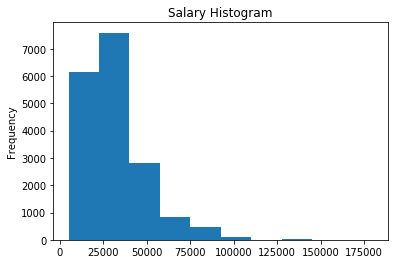

In [22]:
Salaries_Plot["SalaryNormalized"].plot(kind='hist',title="Salary Histogram")

As can be seen from the histogram above, SalaryNormalized is a skewed distribution showing a positive skewness.

## Model Implementation

In this section, a function is defined, called run_kfold, which uses a 10-fold cross-validation method to train the model, and the mean and variance of the results.

In [23]:
#set up cross validation
def run_kfold(model):
    
    X = Salaries_X
    Y = Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} mean_absolute_error: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

### A Linear Regression

First use the simplest linear regression to predict the model, and use the run_kfold function, 10 fold cross training. Output loss error of training model and loss error of test model

In [24]:
model_lr = linear_model.LinearRegression()
run_kfold (model_lr)

predictions = model_lr.predict(Salaries_X_Test)
Test_Score = r2_score(Salaries_Y_Test, predictions)

print ("------------------\n Test Score: " + str(Test_Score))

Fold 1 mean_absolute_error: 0.4666557203550533
Fold 2 mean_absolute_error: 0.4370846154016761
Fold 3 mean_absolute_error: 0.45952390324999315
Fold 4 mean_absolute_error: -9.546474206352912e+16
Fold 5 mean_absolute_error: 0.47929391701759594
Fold 6 mean_absolute_error: 0.4329074646691934
Fold 7 mean_absolute_error: -5.9624664075164934e+19
Fold 8 mean_absolute_error: -3.327939745983391e+17
Fold 9 mean_absolute_error: -5.100936730827856e+19
Fold 10 mean_absolute_error: 0.49296281114655827
Mean r2: -1.1106229010010536e+19
Standard Deviation: 2.2189395567220056e+19
------------------
 Test Score: -1.19524157609927e+16


### Neural Network

The following uses a multi-layer perceptron to predict the result. First, define a multi-layer perceptron. The number of hidden layers is 10, 8, and 4, and the number of iterations is 1000.

In [25]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8,4), random_state=1, max_iter=1000)
clf.fit(Salaries_X, Salaries_Y)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 8, 4), learning_rate='constant',
             learning_rate_init=0.001, max_iter=1000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [26]:
clf.score(Salaries_X, Salaries_Y)

0.6453620187383418

In [27]:
clf.score(Salaries_X_Test, Salaries_Y_Test) #overfitting..

0.45375735651311544

As shown above, the training model score is 0.46365568893171605, and the test model score is 0.46365568893171605. Therefore, the multilayer perceptron is over-fitting, so over-fitting needs to be solved, and over-fitting is mitigated by using 10-fold cross-validation.

In [28]:
run_kfold(clf)

Fold 1 mean_absolute_error: 0.4142821706484384
Fold 2 mean_absolute_error: 0.3831965252592294
Fold 3 mean_absolute_error: 0.29507781112568443
Fold 4 mean_absolute_error: 0.4527030417065805
Fold 5 mean_absolute_error: 0.47339367679008293
Fold 6 mean_absolute_error: 0.44063573452426863
Fold 7 mean_absolute_error: 0.4069788872089267
Fold 8 mean_absolute_error: -0.33074453978129537
Fold 9 mean_absolute_error: 0.37374138983601135
Fold 10 mean_absolute_error: -3.0228560812720557
Mean r2: -0.01135913839541285
Standard Deviation: 1.0285823572169472


The average result of 10-fold cross-training is 0.31461086352081835, which is very close to the test model. Therefore, the model of 10-fold cross-training is relatively better and it is not easy to over-fitting.

## Feature Selection

### Recursive Feature Elimination

> scikit-learn:   
> Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.   
> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [29]:
rfe = RFE(model_lr)
fit = rfe.fit(Salaries_X[0:10000], Salaries_Y[0:10000]) #Sampling because of slow run time

In [30]:
sorted(list(zip(fit.ranking_,Salaries_X))[0:10])

[(1, 'LocationNormalized_Belfast'),
 (1, 'LocationNormalized_Berkshire'),
 (1, 'LocationNormalized_Birmingham'),
 (1, 'LocationNormalized_Bradford'),
 (1, 'LocationNormalized_Bristol'),
 (1, 'LocationNormalized_Cambridge'),
 (1, 'LocationNormalized_Central London'),
 (1, 'LocationNormalized_Edinburgh'),
 (1, 'LocationNormalized_Glasgow'),
 (1, 'LocationNormalized_Hampshire')]

###  Lasso Regularization

> Linear Model trained with L1 prior as regularizer (aka the Lasso)   
> #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [31]:
reg = linear_model.Lasso(alpha = 0.5,max_iter=10000)
reg.fit(Salaries_X, Salaries_Y)
reg.score(Salaries_X, Salaries_Y)

0.48176951117892985

### Grid Search

Any machine learning model comes with many parameters. Different scenes correspond to different optimal parameters. It is a waste of time to manually try various parameters. Therefore, in this part, we use grid search to find the optimal parameters. The basic model is linear. Regression, the adjustment parameter is alpha.

In [32]:
from sklearn.metrics import make_scorer, r2_score, confusion_matrix

reg_gridsearch = linear_model.Lasso(random_state=42)
#Parameters to test
parameters = {'alpha':[0.5,1,3], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

# Run the grid search
grid_obj_lm = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm)
grid_obj_lm = grid_obj_lm.fit(Salaries_X, Salaries_Y)

reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination

In [33]:
reg_gridsearch # print out the optimal params so grid search does not need to be rerun

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=42, selection='cyclic',
      tol=0.0001, warm_start=False)

In [34]:
reg_gridsearch.fit(Salaries_X, Salaries_Y)
reg_gridsearch.score(Salaries_X, Salaries_Y)

0.47688361888749586

In [35]:
print('alpha (Constant that multiplies the L1 term):',grid_obj_lm.best_estimator_.alpha) 
print('normalize:',grid_obj_lm.best_estimator_.normalize)
predictions_lasso = reg_gridsearch.predict(Salaries_X_Test)
mean_absolute_error(Salaries_Y_Test,predictions_lasso)

alpha (Constant that multiplies the L1 term): 0.5
normalize: True


8575.15442806187

In [36]:
run_kfold (reg)

Fold 1 mean_absolute_error: 0.4672859706461081
Fold 2 mean_absolute_error: 0.43785436175113224
Fold 3 mean_absolute_error: 0.4597764439297509
Fold 4 mean_absolute_error: 0.4438231065515843
Fold 5 mean_absolute_error: 0.4801695373393484
Fold 6 mean_absolute_error: 0.4334180465740146
Fold 7 mean_absolute_error: 0.41195086609464227
Fold 8 mean_absolute_error: 0.3800840047375893
Fold 9 mean_absolute_error: 0.43393730189283564
Fold 10 mean_absolute_error: 0.49285806676228194
Mean r2: 0.4441157706279288
Standard Deviation: 0.0313843622357679


In [37]:
# can see more consistent results with regularization than regular linear regression
sorted(list(zip(reg.coef_, Salaries_X)),reverse=True)[0:10]

[(36515.946785267566, 'nurse practitioner'),
 (19970.360599076626, 'intensive care'),
 (15440.703984317071, 'Category_Energy, Oil & Gas Jobs'),
 (11482.071441354838, 'care assistant job'),
 (10023.221643001467, 'LocationNormalized_The City'),
 (9584.683939248784, 'social worker'),
 (9265.75483908982, 'Category_Healthcare & Nursing Jobs'),
 (9082.94047673813, 'Category_IT Jobs'),
 (8962.418195570393, 'account director'),
 (8823.936080731088, 'systems engineer')]

In [38]:
#Can see that regularized coefficeints are more reasonable 
rfe_lasso = RFE(reg)
fit_lasso = rfe_lasso.fit(Salaries_X[0:10000], Salaries_Y[0:10000]) #Sampling because of slow run time
sorted(list(zip(model_lr.coef_, Salaries_X))[0:10])

[(2427908845066226.0, 'LocationNormalized_Bradford'),
 (2427908845066626.5, 'LocationNormalized_Belfast'),
 (2427908845069580.5, 'LocationNormalized_Cambridge'),
 (2427908845069661.5, 'LocationNormalized_Birmingham'),
 (2427908845071154.5, 'LocationNormalized_Bristol'),
 (2427908845072127.5, 'LocationNormalized_Hampshire'),
 (2427908845072428.0, 'LocationNormalized_Edinburgh'),
 (2427908845073439.5, 'LocationNormalized_Berkshire'),
 (2427908845073891.0, 'LocationNormalized_Glasgow'),
 (2427908845074646.0, 'LocationNormalized_Central London')]

### PCA

In [39]:
# does not show any improvements - higher score with more components
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
pca.fit(Salaries_X)
PCA_X = pca.transform(Salaries_X)
PCA_X_Test = pca.transform(Salaries_X_Test)
model_lr_pca = linear_model.LinearRegression()
model_lr_pca.fit(PCA_X,Salaries_Y)

predictions_pca_train = model_lr_pca.predict(PCA_X)
predictions_pca_test = model_lr_pca.predict(PCA_X_Test)

print ("Train r2 Score")
print (r2_score(Salaries_Y, predictions_pca_train))  
print ("Test r2 Score")
print (r2_score(Salaries_Y_Test,predictions_pca_test))

Train r2 Score
0.333333100890685
Test r2 Score
0.33761209717835083


As can be seen from the above, after the PCA dimension reduction, the results of the verification set are very close to the results of the test set, and the effect is not bad.